In [188]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_validate, cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression, Ridge
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, plot_confusion_matrix
from sklearn.feature_extraction.text import CountVectorizer
# Add your imports below
from sklearn.metrics import make_scorer
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.neighbors import NearestNeighbors
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances, euclidean_distances


In [189]:
def cross_validate_std(*args, **kwargs):
    """Like cross_validate, except also gives the standard deviation of the score"""
    res = pd.DataFrame(cross_validate(*args, **kwargs))
    res_mean = res.mean()

    res_mean["std_test_score"] = res["test_score"].std()
    if "train_score" in res:
        res_mean["std_train_score"] = res["train_score"].std()
    return res_mean

## The dataset

[SMS Spam Collection Dataset](https://www.kaggle.com/uciml/sms-spam-collection-dataset). The task is to predict whether a text message (SMS) is spam or not spam ("ham").

In [190]:
sms_df = pd.read_csv("spam.csv", encoding="latin-1")
sms_df = sms_df.drop(columns=["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])
sms_df = sms_df.rename(columns={"v1": "target", "v2": "sms"})

In [191]:
df_train, df_test = train_test_split(sms_df, random_state=123)
df_train.head()

,target,sms
647,spam,PRIVATE! Your 2003 Account Statement for shows...
3843,ham,"Yeah that's what I thought, lemme know if anyt..."
3044,ham,"Hello, yeah i've just got out of the bath and ..."
2536,ham,You do what all you like
4644,ham,Are you planning to come chennai?


In [192]:
df_train.shape

(4179, 2)

Build a classification model to predict whether a message is spam or ham.

In [193]:
X_train = df_train["sms"]
y_train = df_train["target"]

X_test = df_test["sms"]
y_test = df_test["target"]

- Use `CountVectorizer` to create features from the text data.
- Choose an appropriate baseline model (`DummyClassifier` or `DummyRegressor` to predict spam vs. ham and report the relevant scores
- Choose an appropriate linear model (`LogisticRegression` or `Ridge`) to predict spam vs. ham
- Choose an appropriate random forest model (`RandomForestClassifier` or `RandomForestRegressor`) to predict spam vs. ham
- Report the relevant scores for your two models above. You can keep default hyperparameters for simplicity.
- Report the most important features according to your linear model.

In [194]:
countvec = CountVectorizer(min_df=50, stop_words='english')
countvec.fit(X_train)
X_train_countvec = countvec.transform(X_train)
X_test_countvec = countvec.transform(X_test)
X_train_countvec.shape

(4179, 87)

In [195]:
dc = DummyClassifier(strategy='prior')
dc.fit(X_train_countvec, y_train)
dc.score(X_test_countvec, y_test)

0.87724335965542

In [196]:
r = LogisticRegression()
pipe_r = make_pipeline(countvec, r)
pipe_r.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=50, stop_words='english')),
                ('logisticregression', LogisticRegression())])

In [197]:
cross_validate_std(pipe_r, X_train, y_train)

fit_time          0.055543
score_time        0.009401
test_score        0.946876
std_test_score    0.004138
dtype: float64

In [198]:
pipe_r.score(X_test, y_test)

0.9605168700646087

In [199]:
rf = RandomForestClassifier()
pipe_rf = make_pipeline(countvec, rf)
pipe_rf.fit(X_train, y_train)

Pipeline(steps=[('countvectorizer',
                 CountVectorizer(min_df=50, stop_words='english')),
                ('randomforestclassifier', RandomForestClassifier())])

In [200]:
cross_validate_std(pipe_rf, X_train, y_train)

fit_time          0.278986
score_time        0.028260
test_score        0.945918
std_test_score    0.005343
dtype: float64

In [201]:
pipe_rf.score(X_test, y_test)

0.9583632447954056

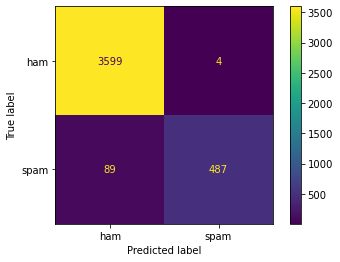

In [202]:
plot_confusion_matrix(pipe_rf, X_train, y_train, display_labels=['ham', 'spam']);

In [203]:
cross_validate_std(pipe_rf, X_train, y_train, scoring=make_scorer(precision_score, pos_label='spam'))

fit_time          0.288315
score_time        0.032084
test_score        0.888648
std_test_score    0.050948
dtype: float64

In [204]:
cross_validate_std(pipe_rf, X_train, y_train, scoring=make_scorer(recall_score, pos_label='spam'))

fit_time          0.282224
score_time        0.032808
test_score        0.708336
std_test_score    0.013068
dtype: float64

In [205]:
cross_validate_std(pipe_rf, X_train, y_train, scoring=make_scorer(f1_score, pos_label='spam'))

fit_time          0.275068
score_time        0.031142
test_score        0.790908
std_test_score    0.017197
dtype: float64

In [206]:
precision_score(y_train, pipe_rf.predict(X_train), pos_label='spam')

0.9918533604887984

In [207]:
recall_score(y_train, pipe_rf.predict(X_train), pos_label='spam')

0.8454861111111112

In [208]:
f1_score(y_train, pipe_rf.predict(X_train), pos_label='spam')

0.9128397375820057

In [209]:
importances = pd.DataFrame(data=pipe_rf[1].feature_importances_, index=pipe_rf[0].get_feature_names(), columns=["Importance"])
importances.sort_values(by="Importance", ascending=False).head()

,Importance
txt,0.086977
free,0.086922
claim,0.076506
mobile,0.073112
www,0.061054


'txt' is the most important feature

## Using pre-trained word embeddings.

We will use a package called [spaCy](https://spacy.io/). 

In [211]:
X_train.iloc[0]

'PRIVATE! Your 2003 Account Statement for shows 800 un-redeemed S. I. M. points. Call 08715203694 Identifier Code: 40533 Expires 31/10/04'

In [212]:
nlp(X_train.iloc[0]).vector

array([-6.31907508e-02,  1.87776491e-01, -3.50111164e-02, -1.40975965e-02,
        6.48319796e-02, -6.47449717e-02,  1.70375593e-02, -6.10386357e-02,
       -1.64511222e-02,  1.32269633e+00, -2.01264426e-01,  1.75327167e-01,
       -1.92099977e-02, -7.02716932e-02, -4.06776555e-02,  4.39935699e-02,
       -9.40892398e-02,  1.16417742e+00,  5.21034896e-02, -4.15729620e-02,
       -6.67720437e-02,  2.09751315e-02, -2.88010016e-02, -1.74403172e-02,
        7.59456381e-02,  1.59054156e-02, -1.19963408e-01, -4.00383957e-02,
        6.05901927e-02,  6.71593547e-02,  9.76373553e-02,  3.17107029e-02,
        3.25630940e-02,  1.04522884e-01, -4.10015620e-02, -1.43015515e-02,
       -5.64244464e-02,  8.83771945e-03, -5.06912246e-02, -5.84236719e-02,
       -7.24398345e-02, -6.05546385e-02,  1.38748854e-01, -1.05185993e-01,
       -1.15349621e-01,  8.07616413e-02, -3.67925540e-02,  1.33814156e-01,
        4.17499691e-02,  1.61221206e-01, -7.78133571e-02,  2.88000386e-02,
       -8.40148050e-03, -

This is analogous to calling `transform` with `CountVectorizer`.

Compare the _length of the representation_ for these embeddings vs. the `CountVectorizer` approach. Then, compare the _number of nonzero entries_ for the two repesentations of the first training example. Briefly discuss.

Note: A common error here is that scikit-learn methods expect certain data shapes as their input. To address this use `X_train.iloc[[0]]` instead of `X_train.iloc[0]`.

In [213]:
nlp(X_train.iloc[0]).vector.shape

(300,)

In [214]:
X_train_countvec[0].shape

(1, 87)

In [215]:
np.count_nonzero(nlp(X_train.iloc[0]))

25

In [216]:
x = (X_train_countvec[0].toarray())

In [217]:
np.sum(x != 0)

0

In [218]:
X_train_countvec[0]

<1x87 sparse matrix of type '<class 'numpy.int64'>'
	with 0 stored elements in Compressed Sparse Row format>

---- Discuss:
With the en_core_web_md nlp model all the words will be non-zero, since each word is given a embedding score based on the large pre-training data this model has. X_train_countvec[0] is a sparse matrix with 0 stored elements in Compressed Sparse row format and so the first row has no non-zero elements.

## Using Pre-trained Embedding Model
We used `CountVectorizer` to generate features, which were then fed into a model. We can do the same here with the features from the pre-trained embedding model. 

In this case, for computational reasons I will first get the embeddings for the entire train and test sets (note that this doesn't violate the Golden Rule because the transformation is independent for each example):

In [219]:
X_train_embeddings = pd.DataFrame([sms.vector for sms in nlp.pipe(X_train)])
X_test_embeddings  = pd.DataFrame([sms.vector for sms in nlp.pipe(X_test)])

In [220]:
X_train_embeddings.shape

(4179, 300)

What sort of scores can you get with these features instead? 

In [221]:
r = LogisticRegression()
r.fit(X_train_embeddings, y_train)

LogisticRegression()

In [222]:
cross_validate_std(r, X_train_embeddings, y_train)

fit_time          0.328618
score_time        0.004213
test_score        0.964106
std_test_score    0.002244
dtype: float64

In [223]:
cross_validate_std(r, X_train_embeddings, y_train, scoring=make_scorer(precision_score, pos_label='spam'))

fit_time          0.306391
score_time        0.006998
test_score        0.900167
std_test_score    0.022923
dtype: float64

In [224]:
cross_validate_std(r, X_train_embeddings, y_train, scoring=make_scorer(recall_score, pos_label='spam'))

fit_time          0.295814
score_time        0.007000
test_score        0.833238
std_test_score    0.040367
dtype: float64

In [225]:
cross_validate_std(r, X_train_embeddings, y_train, scoring=make_scorer(f1_score, pos_label='spam'))

fit_time          0.299244
score_time        0.007058
test_score        0.864507
std_test_score    0.012753
dtype: float64

In [226]:
rf = RandomForestClassifier()
rf.fit(X_train_embeddings, y_train)

RandomForestClassifier()

In [227]:
cross_validate_std(rf, X_train_embeddings, y_train)

fit_time          1.936818
score_time        0.017495
test_score        0.971763
std_test_score    0.005258
dtype: float64

In [228]:
cross_validate_std(rf, X_train_embeddings, y_train, scoring=make_scorer(precision_score, pos_label='spam'))

fit_time          1.888121
score_time        0.018830
test_score        0.981063
std_test_score    0.013918
dtype: float64

In [229]:
cross_validate_std(rf, X_train_embeddings, y_train, scoring=make_scorer(recall_score, pos_label='spam'))

fit_time          1.927317
score_time        0.017583
test_score        0.805412
std_test_score    0.049823
dtype: float64

In [230]:
cross_validate_std(rf, X_train_embeddings, y_train, scoring=make_scorer(f1_score, pos_label='spam'))

fit_time          1.949642
score_time        0.019971
test_score        0.884793
std_test_score    0.026779
dtype: float64

---- Discuss: 
Using these features we are getting better cross-validation scores for both LogisticRegression and RandomForest, and 
much better precision, recall and f-1 score for RandomForest.

The nlp model that extracted these features was pre-trained on a very large dataset and can identify similarity, meaning and relationship of the words in the example relative to other words based on the word embedding scores. This allowed this model to have a better scores across the board and also lower standard deviation.


## Model scores on the test data:

In [231]:
r.score(X_test_embeddings, y_test)

0.9676956209619526

In [232]:
rf.score(X_test_embeddings, y_test)

0.9755922469490309

--- Discuss:
The test and train score are very close. This is expected as the training score was not entirely based on the training set, but rather the large pre-training dataset and the pre-trained word embedding the model has.

## Finding similar messages to a query message using nearest neighbours

Using scikit-learn's `NearestNeighbours` on the word count features from `CountVectorizer`, searching the training data to find the 5 most similar messages to this made-up message:

In [233]:
query_sms = "Hey how about some CPSC 330 studying over Zoom or socially distanced at a park? This course is so much fun right?"

Part a) Use Euclidean distance and the same `CountVectorizer` you used in Exercise 1.

Note: The `kneighbors` function returns indices of the neighbours. To retrieve the corresponding messages, I recommend indexing using the `iloc` syntax.

Note: We don't exactly have a notion of train and test anymore, because we're not doing supervised learning anymore. I just picked the training set for simplicity.

In [234]:
X_train_countvec

<4179x87 sparse matrix of type '<class 'numpy.int64'>'
	with 8599 stored elements in Compressed Sparse Row format>

In [249]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_countvec)

NearestNeighbors()

In [250]:
similar_sms = nn.kneighbors(countvec.transform([query_sms]))

In [252]:
for i in similar_sms[1][0]:
    print(X_train.iloc[i])

Hey... Very inconvenient for your sis a not huh?
I meant middle left or right?
Hey company elama po mudyadhu.
Hey u still at the gym?
Kate jackson rec center before 7ish, right?


## Repeat part (a) but using cosine similarity instead of Euclidean distance to make part (b)

In [253]:
nn_cosine = NearestNeighbors(n_neighbors=5, metric='cosine')
nn_cosine.fit(X_test_countvec)

NearestNeighbors(metric='cosine')

In [240]:
similar_sms_cosine = nn_cosine.kneighbors(countvec.transform([query_sms]))

In [241]:
for i in similar_sms_cosine[1][0]:
    print(X_train.iloc[i])

Ringtone Club: Get the UK singles chart on your mobile each week and choose any top quality ringtone! This message is free of charge.
I cant wait to see you! How were the photos were useful? :)
Fffff. Can you text kadeem or are you too far gone
Anything lar...
We have sent JD for Customer Service cum Accounts Executive to ur mail id, For details contact us


## Repeat parts (a) and (b) but this time with the pre-trained embeddings.

In [254]:
nn = NearestNeighbors(n_neighbors=5)
nn.fit(X_train_embeddings)
query = nlp(query_sms)
similar_sms = nn.kneighbors([query.vector])[1]
for i in similar_sms[0]:
    print(X_train.iloc[i])

Have you heard about that job? I'm going to that wildlife talk again tonight if u want2come. Its that2worzels and a wizzle or whatever it is?! 
Not a lot has happened here. Feels very quiet. Beth is at her aunts and charlie is working lots. Just me and helen in at the mo. How have you been? 
Do whatever you want. You know what the rules are. We had a talk earlier this week about what had to start happening, you showing responsibility. Yet, every week it's can i bend the rule this way? What about that way? Do whatever. I'm tired of having thia same argument with you every week. And a  &lt;#&gt;  movie DOESNT inlude the previews. You're still getting in after 1.
Exactly. Anyways how far. Is jide her to study or just visiting
Oh ! A half hour is much longer in Syria than Canada, eh ? Wow you must get SO much more work done in a day than us with all that extra time ! *grins*


In [255]:
nn_cosine = NearestNeighbors(n_neighbors=5,metric='cosine')
nn_cosine.fit(X_train_embeddings)
query = nlp(query_sms)
similar_sms_cosine = nn_cosine.kneighbors([query.vector])[1]
for i in similar_sms_cosine[0]:
    print(X_train.iloc[i])



Have you heard about that job? I'm going to that wildlife talk again tonight if u want2come. Its that2worzels and a wizzle or whatever it is?! 
Not a lot has happened here. Feels very quiet. Beth is at her aunts and charlie is working lots. Just me and helen in at the mo. How have you been? 
Exactly. Anyways how far. Is jide her to study or just visiting
Oh ! A half hour is much longer in Syria than Canada, eh ? Wow you must get SO much more work done in a day than us with all that extra time ! *grins*
Do whatever you want. You know what the rules are. We had a talk earlier this week about what had to start happening, you showing responsibility. Yet, every week it's can i bend the rule this way? What about that way? Do whatever. I'm tired of having thia same argument with you every week. And a  &lt;#&gt;  movie DOESNT inlude the previews. You're still getting in after 1.
